In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path
import sys

sys.path.insert(0, '..')
import occRateModels as rm
import occRateUtils as ut

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_berger2019_clean_GK.txt"
pcCatalog = "koiCatalogs/dr25_GK_PCs.csv"

cs = ut.compSpace(periodName = "Period", 
               periodUnits = "Days",
               periodRange = (50, 400), 
               nPeriod = 57, 
               radiusName = "Radius", 
               radiusUnits = "$R_\oplus$",
               rpRange = (0.75, 2.5), 
               nRp = 61)

# for quick tests
# nWalkers = 6
# nBurnin = 200
# nMcmc = 1000
# for production runs
nWalkers = 16
nBurnin = 2000
nMcmc = 5000


model = rm.dualPowerLaw()
# model = rm.gaussiansxPowerLaw()
whichRadii = "corrected"

# make output directory if needed
outDir = "occ_" + model.name + "_out"
if not path.exists(outDir):
    os.mkdir(outDir)

In [3]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    if whichRadii == "corrected Minus 1Sigma":
        return catalog.corrected_prad - catalog.corrected_prad_err1
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string');

In [4]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (cs.periodRange[0] <= base_kois.koi_period) & (base_kois.koi_period <= cs.periodRange[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (cs.rpRange[0] <= thisRadii) & (thisRadii <= cs.rpRange[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois


In [56]:
len(base_kois)

1894

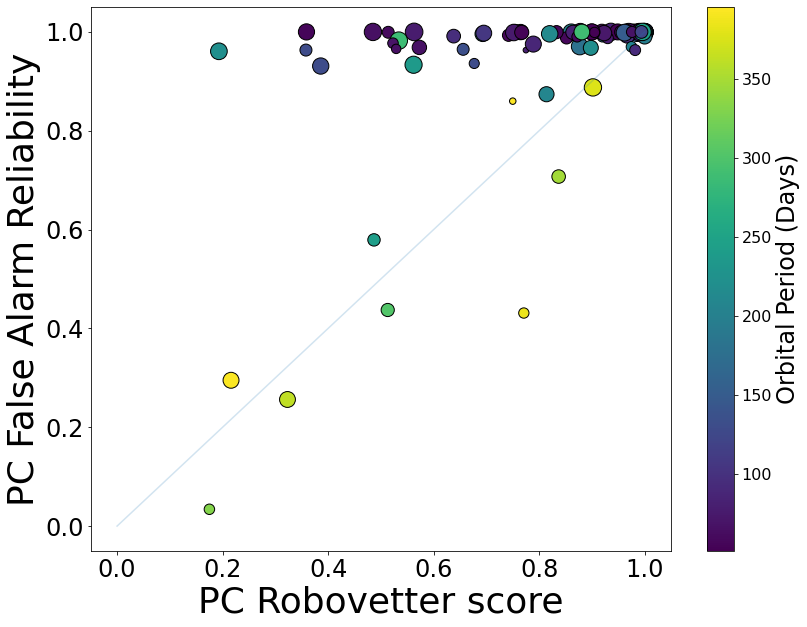

In [53]:
plt.figure(figsize=(13,10));
scf = plt.scatter(kois.koi_score, kois.reliability, s=50*kois.corrected_prad**2, c=kois.koi_period, edgecolors='k')
plt.plot([0, 1], [0, 1], alpha=0.2)
cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Orbital Period (Days)", fontsize = 24);
cbh.ax.tick_params(labelsize=16)
plt.tick_params(labelsize = 24)

plt.xlabel("PC Robovetter score", fontsize = 36);
plt.ylabel("PC False Alarm Reliability", fontsize = 36);
plt.savefig("scoreVsReliability.pdf",bbox_inches='tight')


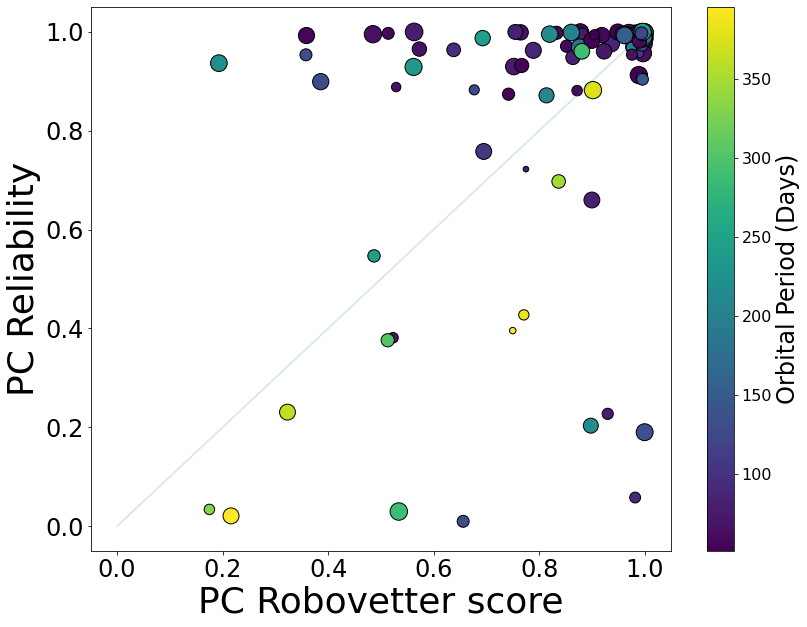

In [54]:
plt.figure(figsize=(13,10));
scf = plt.scatter(kois.koi_score, kois.totalReliability, s=50*kois.corrected_prad**2, c=kois.koi_period, edgecolors='k')
plt.plot([0, 1], [0, 1], alpha=0.2)
cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Orbital Period (Days)", fontsize = 24);
cbh.ax.tick_params(labelsize=16)
plt.tick_params(labelsize = 24)

plt.xlabel("PC Robovetter score", fontsize = 36);
plt.ylabel("PC Reliability", fontsize = 36);
plt.savefig("scoreVsTotalReliability.pdf",bbox_inches='tight')


In [57]:
len(stellarTargets)

57015

(50.0, 400.0)

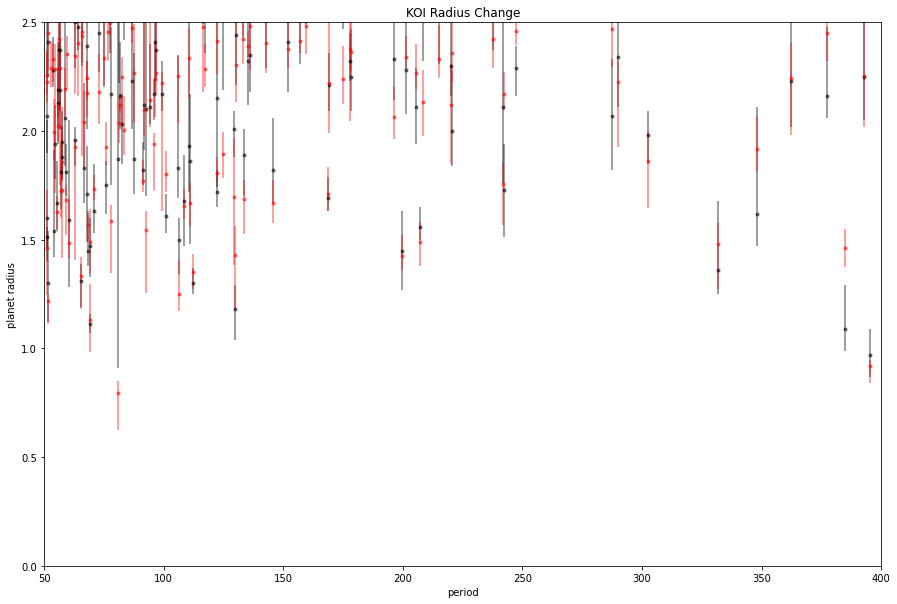

In [5]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(kois.koi_period, kois.koi_prad, 
            yerr = [-kois.koi_prad_err2, kois.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(kois.koi_period, kois.corrected_prad, 
            yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])
plt.xlim([50, 400])




In [6]:
# period = np.linspace(period_rng[0], period_rng[1], n_period)
# rp = np.linspace(rp_rng[0], rp_rng[1], n_rp)
# period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
# periodShape = period_grid.shape



In [7]:

inputgrid = "../completenessContours/out_sc0_GK_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

# interpolate the numerical grids onto the cs.period2D, cs.rp2D space
#print("size probtot = " + str(np.shape(probtot)))
#print("size period_want = " + str(np.shape(period_want)))
#print("size rp_want = " + str(np.shape(rp_want)))

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)



In [8]:
cs.period2D.shape

(57, 61)

In [9]:
summedCompleteness = numCompVeInterp(cs.period1D, cs.rp1D)
summedProbDet = numProbDetInterp(cs.period1D, cs.rp1D)





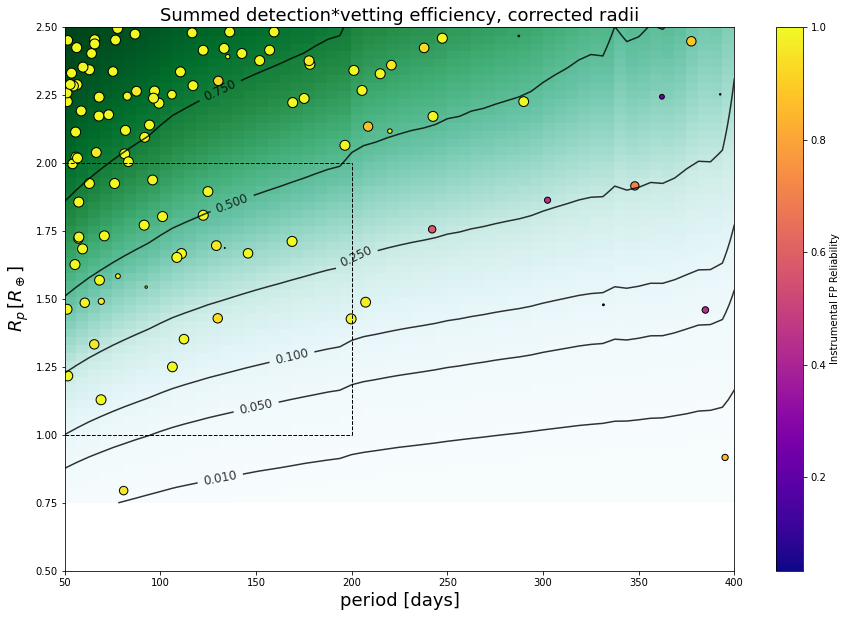

In [10]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]


fig, ax = plt.subplots(figsize=(15,10));

plt.pcolor(cs.period2D, cs.rp2D, summedProbDet, cmap="BuGn")
c = plt.contour(cs.period2D, cs.rp2D, summedProbDet / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.reliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Instrumental FP Reliability");

#c = plt.contour(cs.period2D, cs.rp2D, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.5, 2.5)
plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.3f")
plt.title("Summed detection*vetting efficiency, " + whichRadii + " radii", fontsize = 18)
plt.xlabel("period [days]", fontsize = 18)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 18);
plt.plot([200, 200], [1, 2], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle='--', linewidth=1)





In [11]:
summedProbDet.shape

(57, 61)

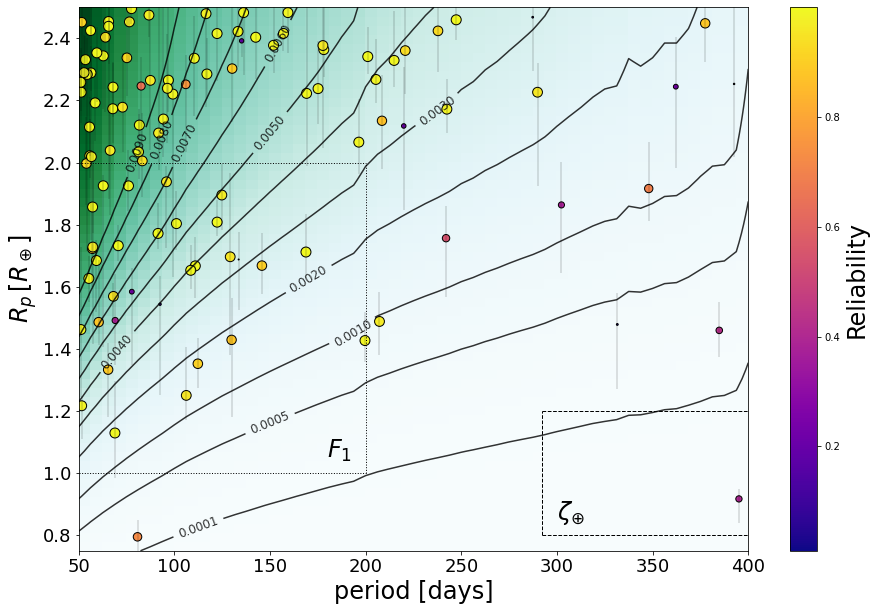

In [12]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = np.arange(1e-3, 1e-2, 1e-3)
contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])

fig, ax = plt.subplots(figsize=(15,10));

plt.pcolor(cs.period2D, cs.rp2D, summedCompleteness, cmap="BuGn")
c = plt.contour(cs.period2D, cs.rp2D, summedCompleteness / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
ax.errorbar(kois.koi_period, getRadii(kois), 
            yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
            fmt="none", ecolor="k", alpha = 0.15, marker = None);
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.totalReliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability", fontsize = 24);

#c = plt.contour(cs.period2D, cs.rp2D, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.75, 2.5)
plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("period [days]", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
plt.plot([200, 200], [1, 2], color='k', linestyle=':', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle=':', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle=':', linewidth=1)
plt.plot([0.8*365, 0.8*365], [0.8, 1.2], color='k', linestyle='--', linewidth=1)
plt.plot([1.2*365, 1.2*365], [0.8, 1.2], color='k', linestyle='--', linewidth=1)
plt.plot([0.8*365, 1.2*365], [0.8, 0.8], color='k', linestyle='--', linewidth=1)
plt.plot([0.8*365, 1.2*365], [1.2, 1.2], color='k', linestyle='--', linewidth=1)
plt.text(180, 1.05, "$F_1$", fontsize = 24)
plt.text(300, 0.85, "$\zeta_{\oplus}$", fontsize = 24)
plt.savefig(outDir + "/summedCompleteness.pdf",bbox_inches='tight')




In [13]:
1.2*365

438.0

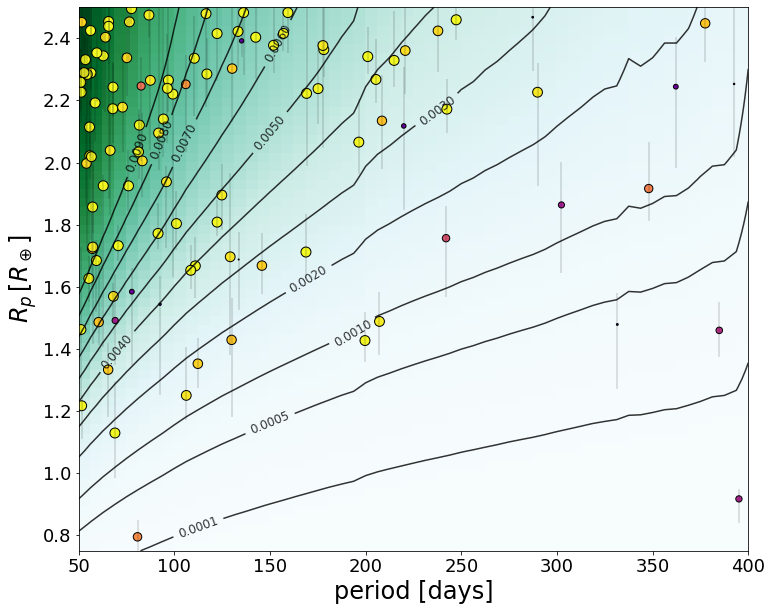

In [14]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = np.arange(1e-3, 1e-2, 1e-3)
contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])

fig, ax = plt.subplots(figsize=(12,10));

plt.pcolor(cs.period2D, cs.rp2D, summedCompleteness, cmap="BuGn")
c = plt.contour(cs.period2D, cs.rp2D, summedCompleteness / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
ax.errorbar(kois.koi_period, getRadii(kois), 
            yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
            fmt="none", ecolor="k", alpha = 0.15, marker = None);
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.totalReliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

# cbh = plt.colorbar(scf);
# cbh.ax.set_ylabel("Reliability", fontsize = 24);

#c = plt.contour(cs.period2D, cs.rp2D, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.75, 2.5)
plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("period [days]", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
plt.savefig(outDir + "/summedCompletenessNoBox.pdf",bbox_inches='tight')



Compute a basic occurrence rate without reliability

../occRateUtils.py:93: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(model.rateModel(koi_periods, koi_rps, cs.periodRange, cs.rpRange, theta))) - norm


$F_0$ = 0.5981231489707618
$\beta$ = -0.5634988606649807
$\alpha$ = 0.3354556507686684


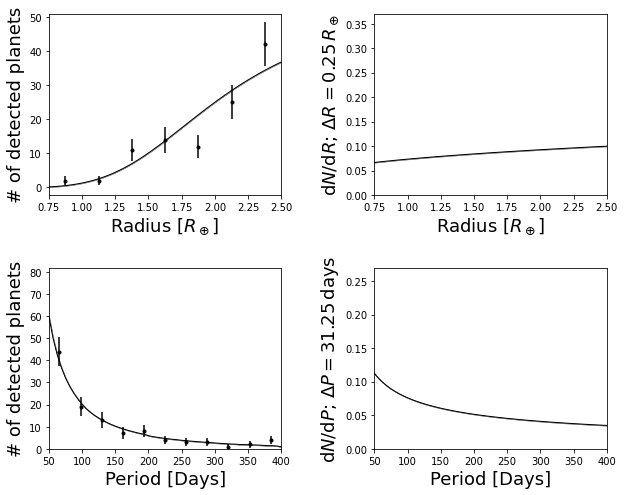

In [15]:
kois = allKois

# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(getRadii(kois))
# koi_rps = getRadii(kois)


# vol = np.diff(cs.period2D, axis=0)[:, :-1] * np.diff(cs.rp2D, axis=1)[:-1, :]

theta_0 = model.initRateModel()
r = minimize(ut.nll, theta_0, method="L-BFGS-B", bounds=model.getBounds(), 
             args=(cs, koi_periods, koi_rps, summedCompleteness, model))
# print(r.x)
ge, fig = ut.plot_results(r.x, cs, koi_rps, koi_periods, summedCompleteness, model);

labels = model.getLabels()
for i in range(len(r.x)):
    print(labels[i] + " = " + str(r.x[i]))

In [16]:
model.rateModel(365.25, 1.0, cs.periodRange, cs.rpRange, r.x)

0.00056571537248974

In [17]:

##################################################################


postName = outDir + "/occurenceRatePosteriors_noreliability.npy"
if path.exists(postName): 
    samples_noreliability = np.load(postName)
    ndim = samples_noreliability.shape[1]
else:
    ndim, nwalkers = len(r.x), nWalkers
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ut.lnprob, 
                                    args=(cs, koi_periods, koi_rps, summedCompleteness, model), threads=8)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, nBurnin)
    sampler.reset()

    # Production.
    start_time = time.time()
    pos, _, _ = sampler.run_mcmc(pos, nMcmc)
    print("--- %s seconds ---" % (time.time() - start_time))

    # kois.to_csv("occurenceRatePosteriors/selectedPcs_noreliability.csv")

    samples_noreliability = sampler.flatchain   
    np.save(postName, samples_noreliability)


--- 37.82541489601135 seconds ---


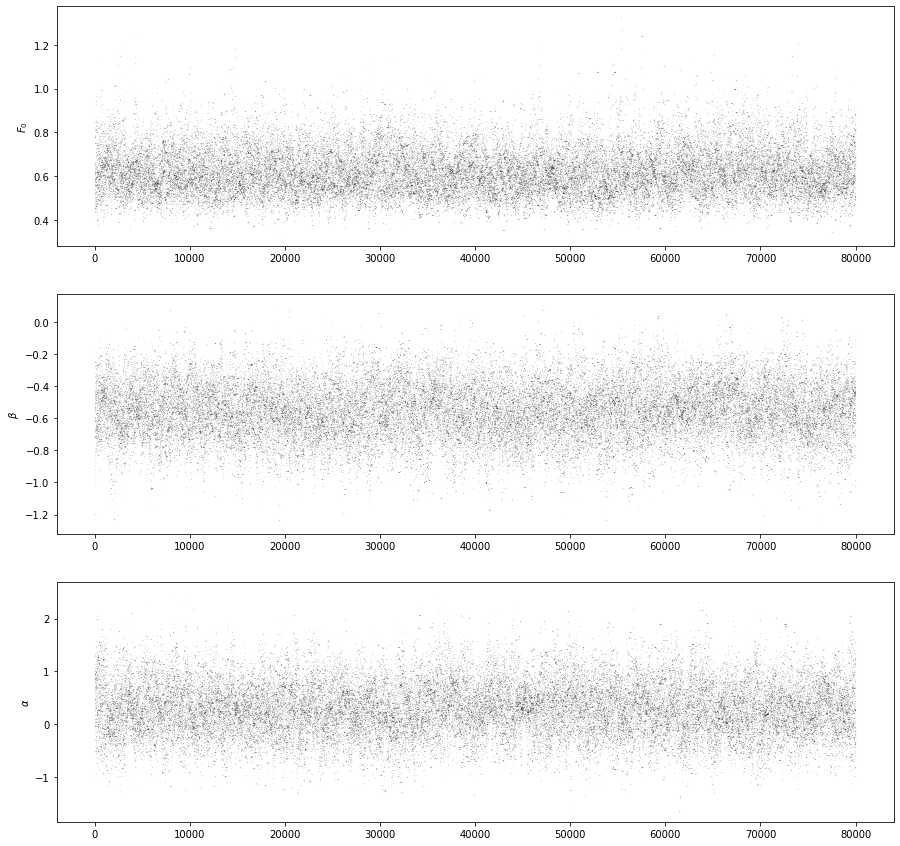

In [18]:
labels = model.getLabels()
fig, axes = plt.subplots(samples_noreliability.shape[1], 1, figsize=(15,15))
for i in range(samples_noreliability.shape[1]):
    ax = axes[i]
    ax.plot(samples_noreliability[:,i], 'k.', markersize=0.2, alpha=0.3)
    ax.set_ylabel(labels[i])


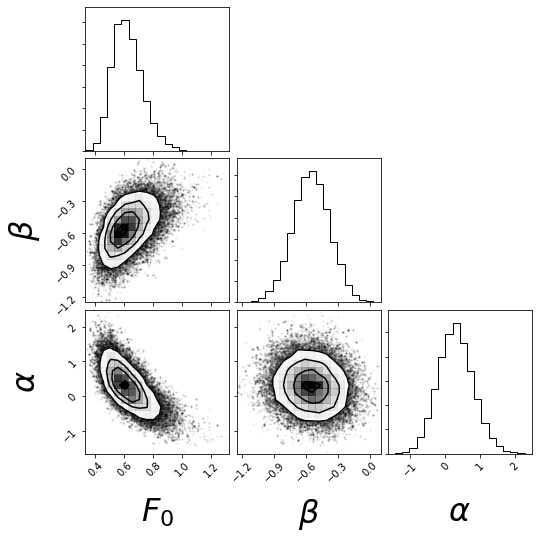

In [19]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=model.getLabels(), label_kwargs = {"fontsize": 32});
plt.savefig(outDir + "/occPostNoReliability.pdf",bbox_inches='tight')


0.2350066596434768


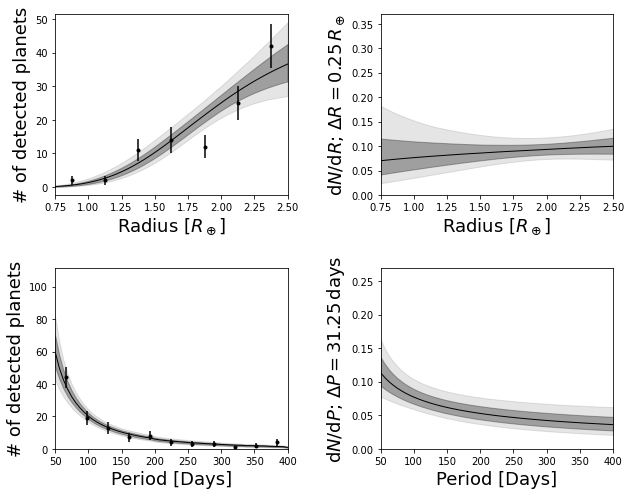

In [20]:
##################################################################

gamma_earth_no_reliability, fig = ut.plot_results(samples_noreliability, cs, 
                                                  koi_rps, koi_periods, summedCompleteness, model)
plt.savefig(outDir + "/occMargNoReliability.pdf",bbox_inches='tight')
print(np.mean(gamma_earth_no_reliability))

##################################################################


In [21]:
labels = model.getLabels()
for i in range(samples_noreliability.shape[1]):
    print(labels[i] + " = " + ut.printMedianAndErrorbars(samples_noreliability[:,i]))

$F_0$ = 0.613^{+0.114}_{-0.092}
$\beta$ = -0.552^{+0.173}_{-0.171}
$\alpha$ = 0.285^{+0.509}_{-0.487}


In [22]:
F1Dist_nr = ut.integrateRateModel([50.,200.], [1., 2.], samples_noreliability, model, cs)
print("1-2Re, 50-200 Days without reliability = " + ut.printMedianAndErrorbars(F1Dist_nr))

F0IntDist_nr = ut.integrateRateModel([50.,400.], [0.75, 2.5], samples_noreliability, model, cs)
print("0.75-2.5Re, 50-400 Days integrated without reliability = " + ut.printMedianAndErrorbars(F0IntDist_nr))



FloatProgress(value=0.0, max=80000.0)

1-2Re, 50-200 Days without reliability = 0.191^{+0.035}_{-0.030}


FloatProgress(value=0.0, max=80000.0)

0.75-2.5Re, 50-400 Days integrated without reliability = 0.613^{+0.114}_{-0.092}


Mean Gamma_Earth = 0.21416179670519703
Gamma at p=365 days, r=1Re without reliability = 0.215^{+0.114}_{-0.076}


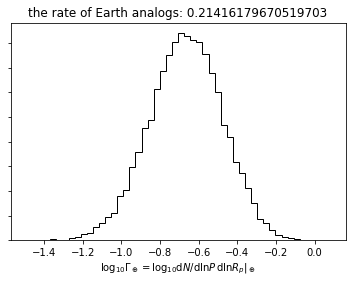

In [23]:

plt.hist(np.log10(gamma_earth_no_reliability), 50, histtype="step", color="k", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(10**np.mean(np.log10(gamma_earth_no_reliability))))
plt.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");

print("Mean Gamma_Earth = {0}".format(10**np.mean(np.log10(gamma_earth_no_reliability))))
print("Gamma at p=365 days, r=1Re without reliability = " + ut.printMedianAndErrorbars(gamma_earth_no_reliability))




Compute an occurrence rate with reliability

In [24]:
nTrials = 100

postName = outDir + "/occurenceRatePosteriors.npy"
# postName = "occurenceRatePosteriors/occurenceRatePosteriors_FAReliability.npy"
if path.exists(postName): 
    allSamples = np.load(postName)
    ndim = allSamples.shape[1]
else:
    f = FloatProgress(min=0, max=nTrials)
    display(f)

    allKois = kois
    for mCount in range(nTrials):
        # randomly select kois

        koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
        # koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
        kois = allKois[koiSelect]
    #    kois.to_csv("occurenceRatePosteriors/selectedPcs" + str  (mCount) + ".csv")
    #    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
    #          + " kois out of " + str(len(allKois)) + " after reliability cut")

        koi_periods = np.array(kois.koi_period)
        koi_rps = np.array(getRadii(kois))

        theta_0 = model.initRateModel()
        r = minimize(ut.nll, theta_0, method="L-BFGS-B", bounds=model.getBounds(), 
                     args=(cs, koi_periods, koi_rps, summedCompleteness, model))

        ##################################################################


        ndim, nwalkers = len(r.x), 2*len(r.x)
        pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ut.lnprob, 
                                        args=(cs, koi_periods, koi_rps, summedCompleteness, model))

        # Burn in.
        pos, _, _ = sampler.run_mcmc(pos, 400)
        sampler.reset()

        # Production.
        pos, _, _ = sampler.run_mcmc(pos, 2000)

        samples = sampler.flatchain   
        if mCount == 0:
            allSamples = samples
        else:
            allSamples = np.concatenate((allSamples, samples))

        f.value += 1
    np.save(postName, allSamples)



FloatProgress(value=0.0)

../occRateUtils.py:93: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(model.rateModel(koi_periods, koi_rps, cs.periodRange, cs.rpRange, theta))) - norm


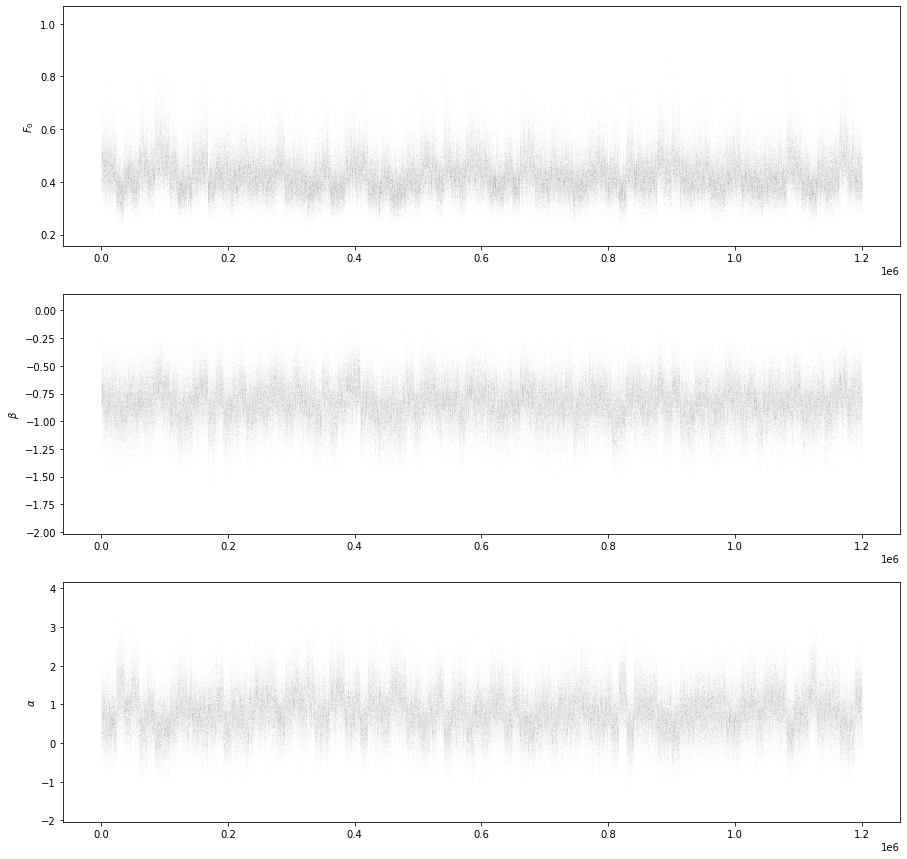

In [25]:
labels = model.getLabels()
fig, axes = plt.subplots(allSamples.shape[1], 1, figsize=(15,15))
for i in range(allSamples.shape[1]):
    ax = axes[i]
    ax.plot(allSamples[:,i], 'k.', markersize=0.2, alpha=0.01)
    ax.set_ylabel(labels[i])


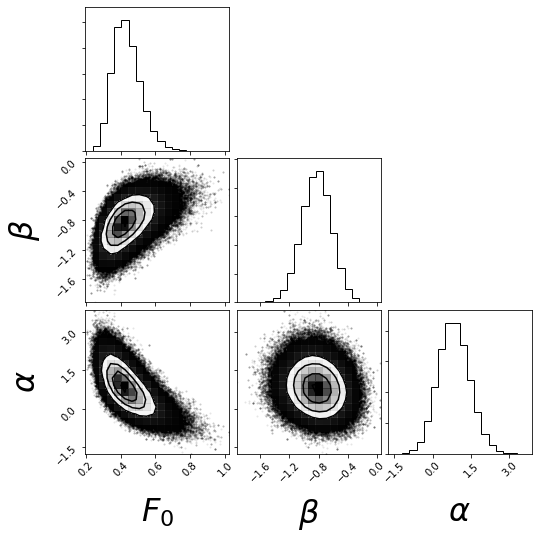

In [26]:
corner.corner(allSamples, labels=model.getLabels(), label_kwargs = {"fontsize": 32});
plt.savefig(outDir + "/occPostReliability.pdf",bbox_inches='tight')




In [27]:
modelLabels = model.getLabels()
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + ut.printMedianAndErrorbars(samples_noreliability[:,i]))
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + ut.printMedianAndErrorbars(allSamples[:,i]))


MCMC no reliability $F_0$=0.613^{+0.114}_{-0.092}
MCMC no reliability $\beta$=-0.552^{+0.173}_{-0.171}
MCMC no reliability $\alpha$=0.285^{+0.509}_{-0.487}
MCMC with reliability $F_0$=0.427^{+0.087}_{-0.069}
MCMC with reliability $\beta$=-0.825^{+0.198}_{-0.204}
MCMC with reliability $\alpha$=0.823^{+0.622}_{-0.592}


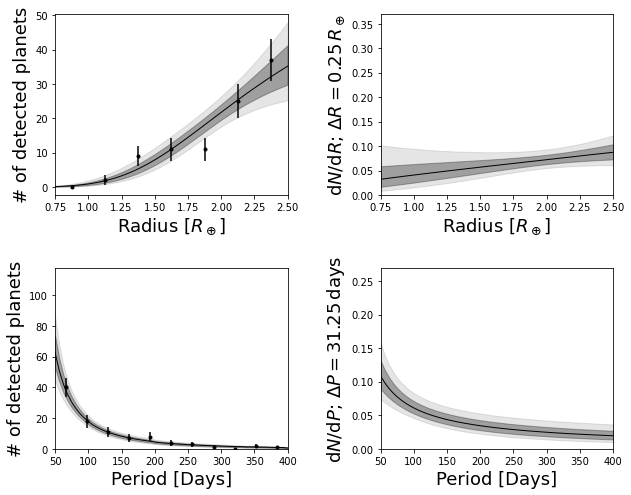

In [28]:
gamma_earth, fig = ut.plot_results(allSamples[:-1:10,:], cs, koi_rps, koi_periods, summedCompleteness, model)
plt.savefig(outDir + "/occMargReliability.pdf",bbox_inches='tight')


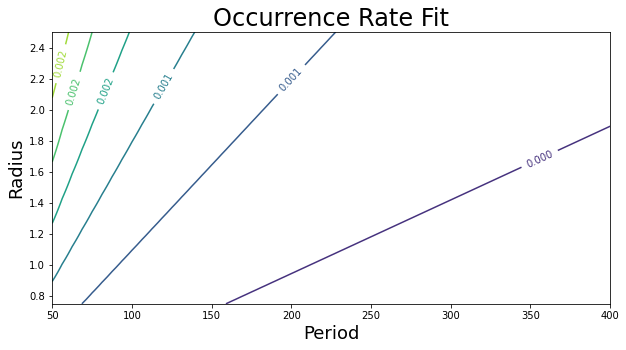

In [29]:
fig, ax = plt.subplots(figsize=(10,5));
rateGrid = model.rateModel(cs.period2D, cs.rp2D, cs.periodRange, cs.rpRange, np.median(allSamples, 0))
CS = ax.contour(cs.period2D, cs.rp2D, rateGrid);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("Period", fontsize = 18);
plt.ylabel("Radius", fontsize = 18);
plt.title("Occurrence Rate Fit", fontsize = 24);


In [30]:
def compare_distributions(d1, d2, textLabel1, textLabel2):
    plt.figure(figsize=(15,10));
    plt.hist(d1, 50, histtype="step", color="k", density=True)
    plt.hist(d2, 50, histtype="step", color="b", density=True)
    plt.gca().set_yticklabels([])
    plt.tick_params(labelsize = 18)

    print(textLabel1 + ut.printMedianAndErrorbars(d1))
    print(textLabel2 + ut.printMedianAndErrorbars(d2))


Gamma at p=365 days, r=1 Re without reliability = 0.215^{+0.114}_{-0.076}
Gamma at p=365 days, r=1 Re = 0.091^{+0.062}_{-0.039}


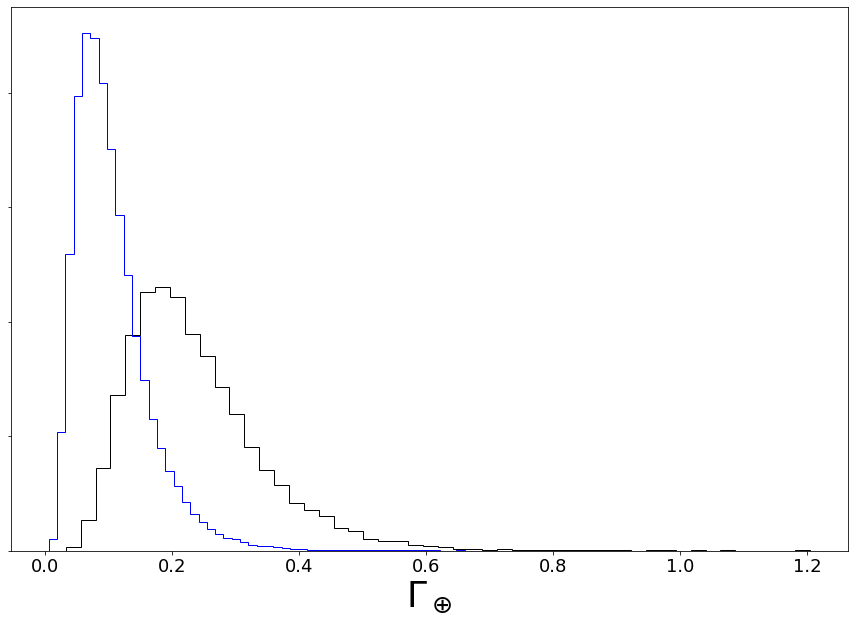

In [31]:
compare_distributions(gamma_earth_no_reliability, gamma_earth, 
                      "Gamma at p=365 days, r=1 Re without reliability = ",
                      "Gamma at p=365 days, r=1 Re = ")

plt.xlabel(r"$\Gamma_\oplus$", fontSize = 36);
plt.tick_params(labelsize = 18)
plt.savefig(outDir + "/gammaDist.pdf",bbox_inches='tight')



F_0 = 50-400 Days, 1.5-2.5 Re without reliability = 0.613^{+0.114}_{-0.092}
F_0 = 50-400 Days, 1.5-2.5 Re = 0.427^{+0.087}_{-0.069}


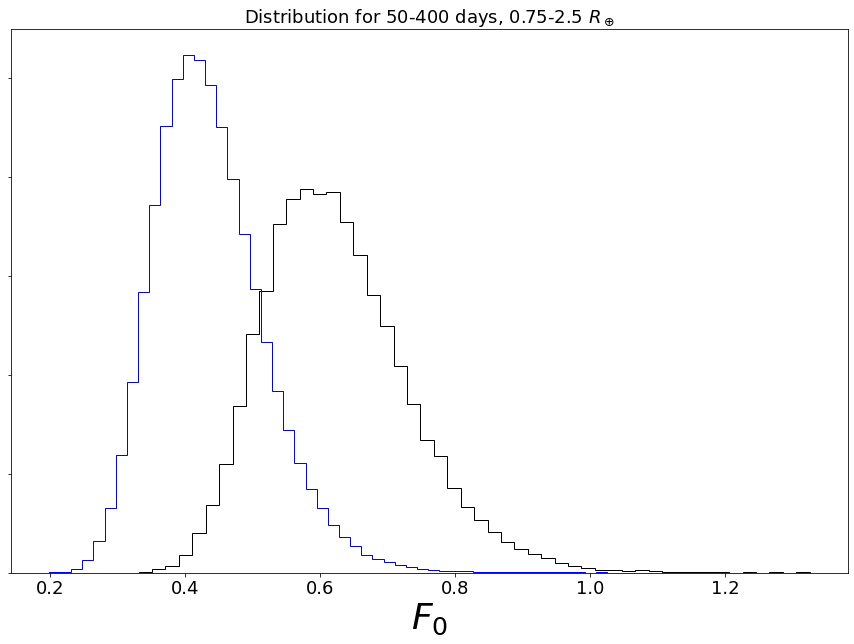

In [32]:
compare_distributions(samples_noreliability[:,0], allSamples[:,0], 
                      "F_0 = 50-400 Days, 1.5-2.5 Re without reliability = ",
                      "F_0 = 50-400 Days, 1.5-2.5 Re = ")
plt.xlabel(r"$F_0$", fontSize = 36);
plt.savefig(outDir + "/f0Dist.pdf",bbox_inches='tight')
plt.title("Distribution for 50-400 days, 0.75-2.5 $R_\oplus$", fontsize=18);


In [33]:
F1Dist = ut.integrateRateModel([50.,200.], [1., 2.], allSamples[:-1:10,:], model, cs)
F1Dist_nr = ut.integrateRateModel([50.,200.], [1., 2.], samples_noreliability, model, cs)


FloatProgress(value=0.0, max=120000.0)

FloatProgress(value=0.0, max=80000.0)

F_1 = 50-200 Days, 1-2Re without reliability = 0.191^{+0.035}_{-0.030}
F_1 = 50-200 Days, 1-2Re = 0.143^{+0.031}_{-0.026}


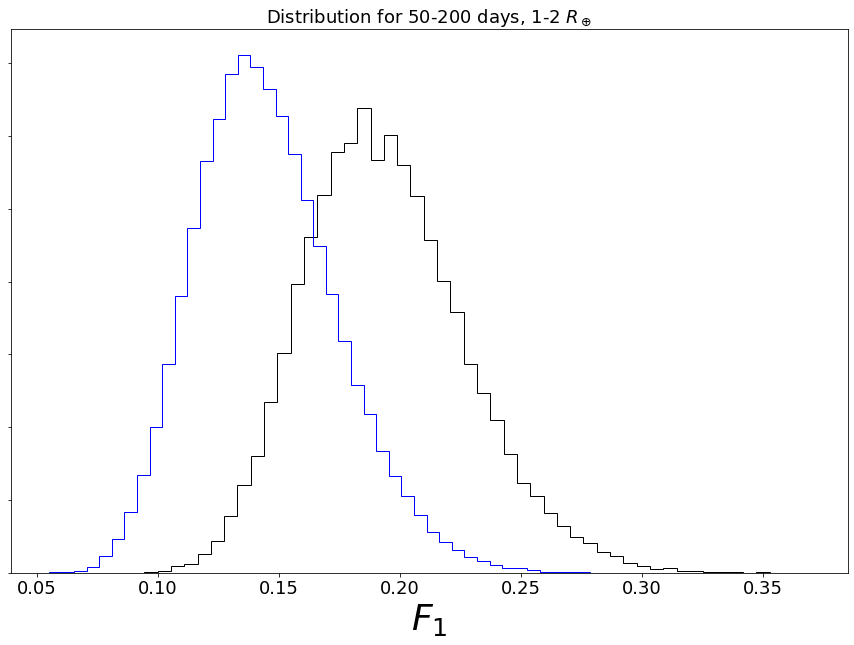

In [34]:
compare_distributions(F1Dist_nr, F1Dist, 
                      "F_1 = 50-200 Days, 1-2Re without reliability = ",
                      "F_1 = 50-200 Days, 1-2Re = ")
plt.xlabel(r"$F_1$", fontSize = 36);
plt.savefig(outDir + "/f1Dist.pdf",bbox_inches='tight')
plt.title("Distribution for 50-200 days, 1-2 $R_\oplus$", fontsize=18);


In [35]:
zetaDist = ut.integrateRateModel([.8*365.25,1.2*365.25], 
                              [0.8,1.2], allSamples[:-1:10,:], model, cs)
zetaDist_nr = ut.integrateRateModel([.8*365.25,1.2*365.25], 
                              [0.8,1.2], samples_noreliability, model, cs)


FloatProgress(value=0.0, max=120000.0)

FloatProgress(value=0.0, max=80000.0)

zeta-Earth without reliability = 0.035^{+0.018}_{-0.012}
zeta-Earth = 0.015^{+0.010}_{-0.006}


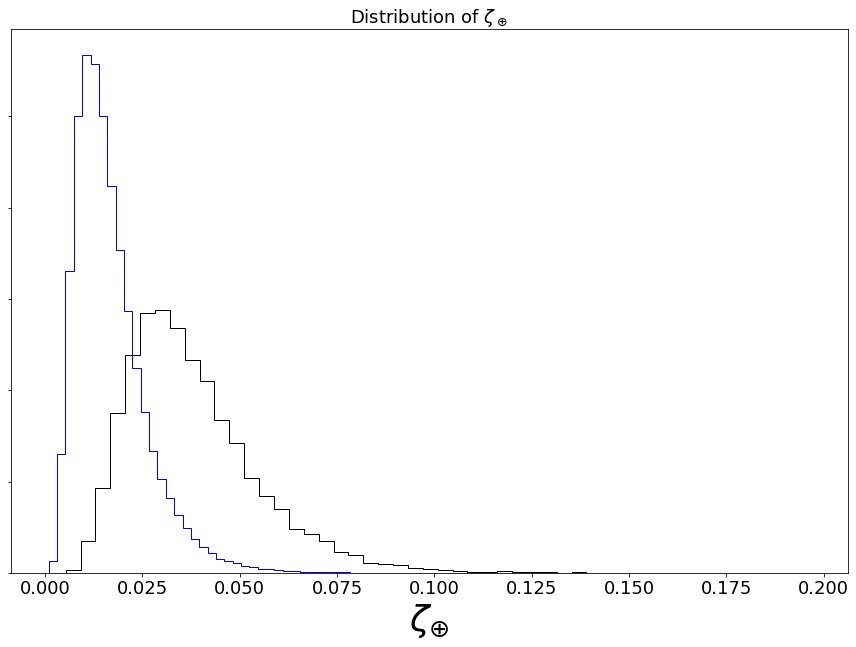

In [36]:
compare_distributions(zetaDist_nr, zetaDist, 
                      "zeta-Earth without reliability = ",
                      "zeta-Earth = ")
plt.xlabel(r"$\zeta_{\oplus}$", fontSize = 36);
plt.savefig(outDir + "/zetaEarthDist.pdf",bbox_inches='tight')
plt.title("Distribution of $\zeta_\oplus$", fontsize=18);


In [37]:
np.save(outDir + "/gammaDistReliability.npy", gamma_earth)
np.save(outDir + "/f1DistReliability.npy", F1Dist)
np.save(outDir + "/zetaDistReliability.npy", zetaDist)


In [38]:
sag13HZDist = ut.integrateRateModel([237,860], [0.5,1.5], allSamples[:-1:10,:], model, cs)
sag13HZDist_nr = ut.integrateRateModel([237,860], [0.5,1.5], samples_noreliability, model, cs)

FloatProgress(value=0.0, max=120000.0)

FloatProgress(value=0.0, max=80000.0)

SAG13 eta Earth without reliability = 0.308^{+0.186}_{-0.114}
SAG13 eta Earth = 0.122^{+0.089}_{-0.052}


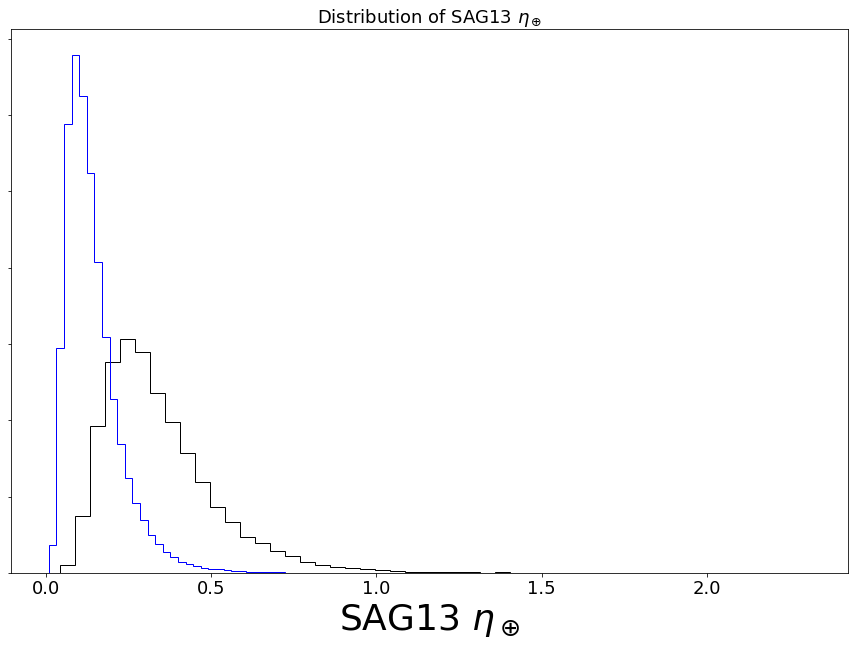

In [39]:
compare_distributions(sag13HZDist_nr, sag13HZDist, 
                      "SAG13 eta Earth without reliability = ",
                      "SAG13 eta Earth = ")
plt.xlabel("SAG13 $\eta_\oplus$", fontSize = 36);
plt.savefig(outDir + "/sag13EtaEarthDist.pdf",bbox_inches='tight')
plt.title("Distribution of SAG13 $\eta_\oplus$", fontsize=18);


In [40]:
hsuFordDist = ut.integrateRateModel([237,500], [1.0,1.75], allSamples[:-1:10,:], model, cs)
hsuFordDist_nr = ut.integrateRateModel([237,500], [1.0,1.75], samples_noreliability, model, cs)

FloatProgress(value=0.0, max=120000.0)

FloatProgress(value=0.0, max=80000.0)

Hsu and Ford eta Earth without reliability = 0.130^{+0.046}_{-0.034}
Hsu and Ford eta Earth = 0.066^{+0.029}_{-0.021}


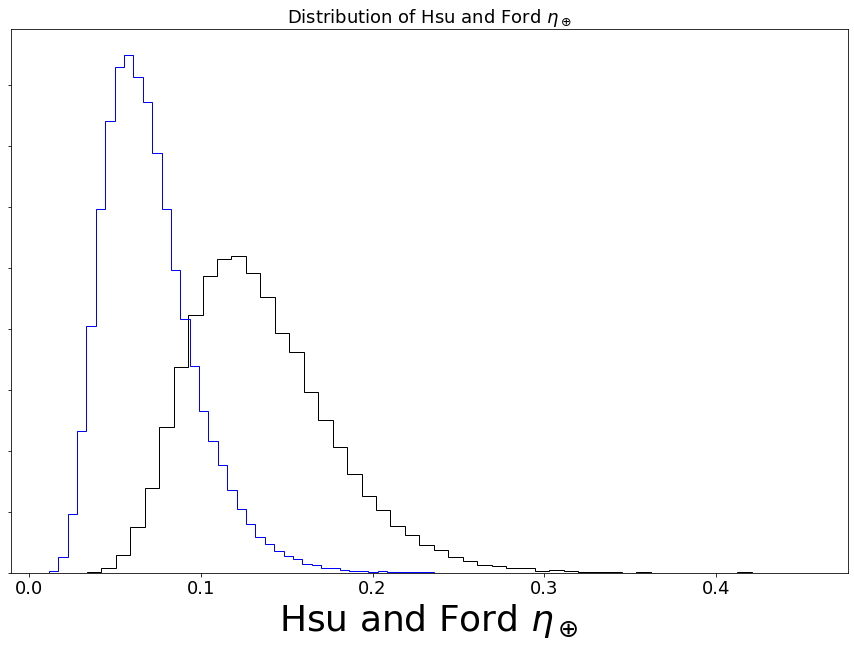

In [41]:
compare_distributions(hsuFordDist_nr, hsuFordDist, 
                      "Hsu and Ford eta Earth without reliability = ",
                      "Hsu and Ford eta Earth = ")
plt.xlabel("Hsu and Ford $\eta_\oplus$", fontSize = 36);
plt.savefig(outDir + "/hsuFordEtaEarthDist.pdf",bbox_inches='tight')
plt.title("Distribution of Hsu and Ford $\eta_\oplus$", fontsize=18);


In [42]:
zinkDist = ut.integrateRateModel([0.61*365,2.216*365], [0.72,1.7], allSamples[:-1:10,:], model, cs)
zinkDist_nr = ut.integrateRateModel([0.61*365,2.216*365], [0.72,1.7], samples_noreliability, model, cs)

FloatProgress(value=0.0, max=120000.0)

FloatProgress(value=0.0, max=80000.0)

Zink eta Earth without reliability = 0.312^{+0.147}_{-0.099}
Zink eta Earth = 0.139^{+0.080}_{-0.051}


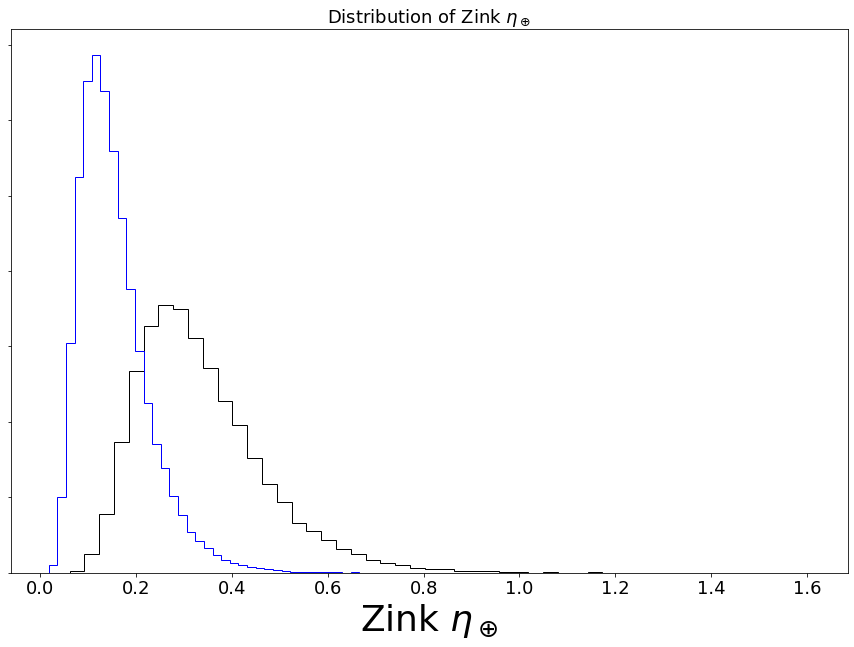

In [43]:
compare_distributions(zinkDist_nr, zinkDist, 
                      "Zink eta Earth without reliability = ",
                      "Zink eta Earth = ")
plt.xlabel("Zink $\eta_\oplus$", fontSize = 36);
plt.savefig(outDir + "/zinkEtaEarthDist.pdf",bbox_inches='tight')
plt.title("Distribution of Zink $\eta_\oplus$", fontsize=18);


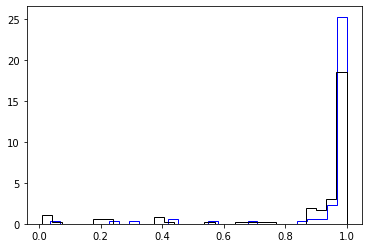

In [44]:
plt.hist(allKois.reliability, 30, histtype="step", color="b", density=True);
plt.hist(allKois.totalReliability, 30, histtype="step", color="k", density=True);

In [45]:
modelName = model.name

In [46]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [47]:
%%bash -s  "$modelName"
jupyter nbconvert --to html computeOccurrence.ipynb
mv computeOccurrence.html htmlArchive/computeOccurrence_$1.html

[NbConvertApp] Converting notebook computeOccurrence.ipynb to html
[NbConvertApp] Writing 2553093 bytes to computeOccurrence.html


In [48]:
[0.61*365,2.216*365]

[222.65, 808.84]